In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [30]:
from _utils import load_mnist
from trainer import Trainer

In [31]:
from argparse import Namespace

config= {
    'train_ratio' : .8,
    'batch_size' : 256,
    'btl_size' : 2,
    'n_epochs' : 50,
    'verbose' : 1,
}
config = Namespace(**config)
print(config)

Namespace(train_ratio=0.8, batch_size=256, btl_size=2, n_epochs=50, verbose=1)


In [32]:
# z에 대해 decoder를 진행한 후 원래의 크기로 돌려주는 함수
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
    
    plt.imshow(x, cmap='gray')
    plt.show()

In [33]:
train_x, train_y = load_mnist(flatten=True) #784차원으로 펴서 반환
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim = 0,
    index=indices,
).split([train_cnt,valid_cnt], dim=0)

train_y, valid_y = torch.index_select(
    train_y,
    dim = 0,
    index=indices,
).split([train_cnt,valid_cnt], dim=0)

print('Train : ', train_x.shape, train_y.shape)
print('Valid : ', valid_x.shape, valid_y.shape)
print('Test : ', test_x.shape, test_y.shape)

Train :  torch.Size([48000, 784]) torch.Size([48000])
Valid :  torch.Size([12000, 784]) torch.Size([12000])
Test :  torch.Size([10000, 784]) torch.Size([10000])


In [34]:
from model import Autoencoder

In [35]:
model = Autoencoder(btl_size = config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model,optimizer,crit)

In [36]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=7.1589e-02  valid_loss=4.9453e-02  lowest_loss=4.9453e-02
Epoch(2/50): train_loss=4.7438e-02  valid_loss=4.5516e-02  lowest_loss=4.5516e-02
Epoch(3/50): train_loss=4.4984e-02  valid_loss=4.3804e-02  lowest_loss=4.3804e-02
Epoch(4/50): train_loss=4.3599e-02  valid_loss=4.2921e-02  lowest_loss=4.2921e-02
Epoch(5/50): train_loss=4.2807e-02  valid_loss=4.1709e-02  lowest_loss=4.1709e-02
Epoch(6/50): train_loss=4.2125e-02  valid_loss=4.2256e-02  lowest_loss=4.1709e-02
Epoch(7/50): train_loss=4.2020e-02  valid_loss=4.1383e-02  lowest_loss=4.1383e-02
Epoch(8/50): train_loss=4.1414e-02  valid_loss=4.0523e-02  lowest_loss=4.0523e-02
Epoch(9/50): train_loss=4.1078e-02  valid_loss=4.0153e-02  lowest_loss=4.0153e-02
Epoch(10/50): train_loss=4.0376e-02  valid_loss=3.9933e-02  lowest_loss=3.9933e-02
Epoch(11/50): train_loss=4.0069e-02  valid_loss=3.9841e-02  lowest_loss=3.9841e-02
Epoch(12/50): train_loss=4.0309e-02  valid_loss=4.0554e-02  lowest_loss=3.9841e-02
Epoch(13/50):

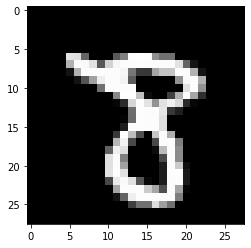

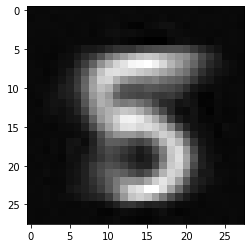

In [37]:
with torch.no_grad():
    import random
    
    index = int(random.random() * test_x.size(0))
    recon = model(test_x[index].view(1,-1)).squeeze()
    
    show_image(test_x[index])
    show_image(recon)

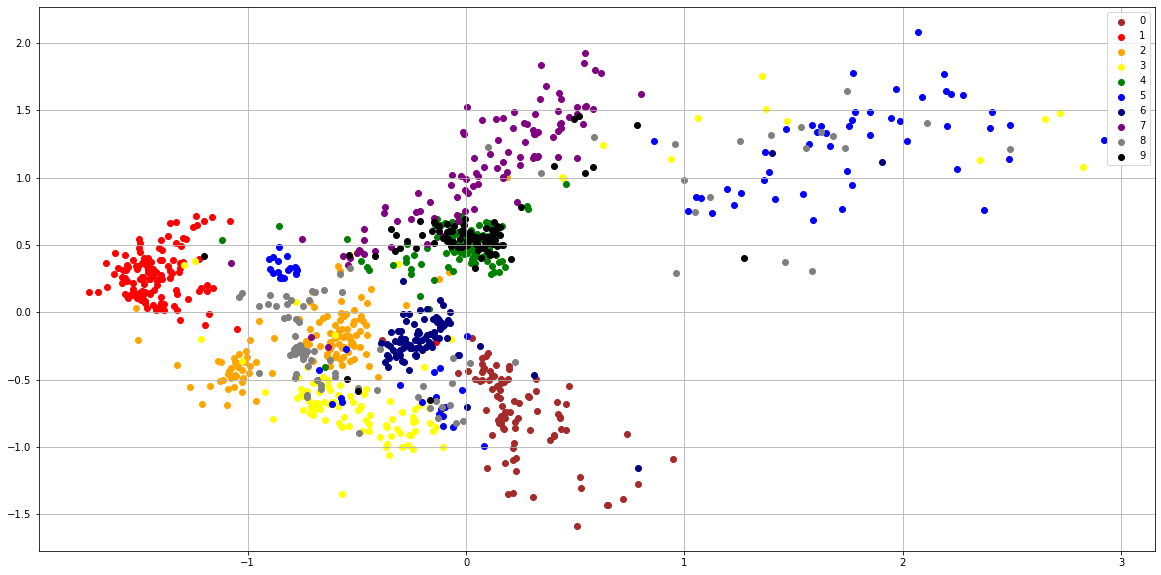

In [38]:
if config.btl_size == 2:
    color_map = ['brown', 'red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'gray', 'black',]
    plt.figure(figsize=(20,10))
    
    with torch.no_grad():
        latens = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latens = latens[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            
            # 산점도 그리기
            plt.scatter(
                target_latens[:,0],
                target_latens[:,1],
                marker='o',
                color=color_map[i],
                label=i,
            )
            
        plt.legend() # 데이터의 범례 표시
        plt.grid(axis='both') # 격자 둘 다 표시
        plt.show()

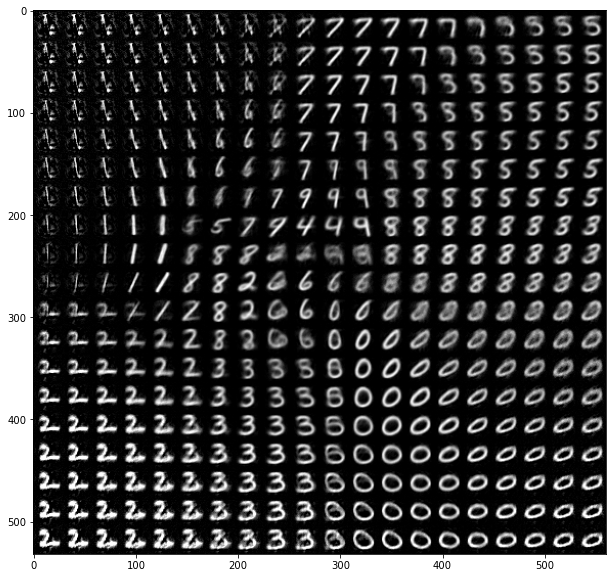

In [39]:
if config.btl_size == 2:
    min_range, max_range = -2, 2
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []
        
        for v1 in np.arange(min_range,max_range,step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,max_range,step)]),
            ], dim = -1)
            
            line = torch.clamp(model.decoder(z).view(n,28,28),0,1)
            line = torch.cat([line[i] for i in range(n-1,0,-1)], dim=0)
            lines += [line]
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20,10))
        show_image(lines)
        